# Solving QAP with PSO

## QAP
The Quadratic Assignment Problem (QAP) is one of the fundamental combinatorial optimization problems in the branch of optimization or operations research in mathematics, from the family of facility location problems.

The problem models the following real-life scenario: Given a set of facilities and a set of locations, with certain distances between each pair of locations and certain flows between each pair of facilities, the goal is to assign all facilities to different locations in such a way that the sum of the products between flows and distances is minimized. Essentially, it's about matching facilities to locations to minimize the overall cost of the distances multiplied by the flows.

Mathematically, the QAP can be formulated as follows:

Given two matrices $D = [d_{ij}]$ and $F = [f_{kl}]$, where $d_{ij}$ represents the distance between locations $i$ and $j$, and $f_{kl}$ represents the flow between facilities $k$ and $l$, the objective is to find a permutation $\pi$ of $N$ elements that minimizes the objective function:

$$
\sum_{i=1}^{N} \sum_{j=1}^{N} f_{\pi(i)\pi(j)} \cdot d_{ij}
$$

The QAP is known to be NP-hard, which means that no efficient algorithm is known to find the optimal solution for all possible instances of the problem within polynomial time. Therefore, heuristic and metaheuristic algorithms, such as tabu search, genetic algorithms, and simulated annealing, are often used to find approximate solutions.

## PSO
Particle Swarm Optimization (PSO) is a computational method that optimizes a problem by iteratively trying to improve a candidate solution with regard to a given measure of quality. PSO simulates the social behavior of birds within a flock or fish in a school and has been successfully applied to various optimization problems, including the Quadratic Assignment Problem (QAP).

Applying PSO to solve the QAP involves adapting the PSO algorithm to handle the discrete nature of the problem, as PSO is inherently designed for continuous spaces. This adjustment can be done through various means, such as mapping the particles' positions to permutations representing assignments of facilities to locations. so a common approach is to use a discrete version of PSO (DPSO) or to modify the velocity and position update rules to suit the discrete nature of QAP solutions. There are 6 general steps to be taken:

1. **Initialization:** Generate a population (swarm) of particles, where each particle represents a potential solution to the QAP (i.e., a specific assignment of facilities to locations). Each particle's position and velocity are initialized randomly.

2. **Evaluation:** Calculate the fitness of each particle according to the QAP cost function. The fitness reflects the quality of the solution, with a lower cost indicating a better solution.

3. **Update Personal and Global Bests:** After each iteration, update each particle's best-known position if its current position is better. Similarly, update the global best if any particle's position is better than the current global best.

4. **Update Velocities and Positions:** Adjust the velocities of the particles based on their own best-known positions and the best-known positions in the swarm. Then, update the positions of the particles accordingly. Position updating in the context of QAP usually involves operations that produce new valid assignments.

5. **Termination:** The algorithm repeats steps 2 through 4 until a termination criterion is met, such as a maximum number of iterations or stagnation in finding better solutions.

PSO for QAP benefits from the simplicity and flexibility of PSO, being relatively easy to implement and capable of exploring the solution space effectively. The major challenge is adapting PSO to handle the discrete nature of QAP efficiently and finding a suitable mapping strategy that faithfully represents the problem's constraints.

In [2]:
#importing the necessary libraries
import random
import matplotlib.pyplot as plt
import math
import numpy as np

In [3]:
random.seed(0)
np.random.seed(0)

In [4]:
D = [] #A 2D array to store the distances between locations
F = [] #A 2D array to store the flow between locations
N  = 0 #Number of locations

def getInput(file_name):
    global N, D, F
    with open(f'./QAPdata/{file_name}.dat', 'r') as file:
        # Read lines in the file
        lines = file.readlines()
        N = int(lines[0])
        D = [list(map(int, row.split())) for row in lines[2:N+2] if len(row.split()) > 0]
        F = [list(map(int, row.split())) for row in lines[N+3:] if len(row.split()) > 0]
    return

**`Particle()` class attributes:**

Each particle is defined by a class that encapsulates several key attributes essential for navigating the search space and evaluating performance within the PSO framework. These attributes include:

- `position`: Represents the particle's current solution in the search space. The initial position is randomely generated if there is no predefined solution sequence given to the object. Each solution is an array of size $N$ where each `position[i]` defines the index of facility in location $i$.

- `velocity`: This is a vector indicating the rate and direction at which the particle moves across the search space. Velocity adjustments are crucial for guiding the particle towards promising regions based on its own experience and the swarm's global knowledge. The velocity in the context of QAP could represent a list of swap operations required to transition from one position to another, offering a way to navigate the discrete search space of QAP.

- `best_position`: This records the particle's optimal position encountered so far, based on the cost function's evaluation. It serves as a historical benchmark, influencing the particle's future movements through its cognitive component, allowing it to leverage personal insights for better decision-making.

- `best_fitness`: This records the cost of the `best_position` attribute.


**`Particle()` class methods:**
The particle class also includes 3 methods as follows:
- `cost()`: This method calculates the cost of particle's solution based on the equation provided at the beginning of the report.

- `update_velocity(global_best_position, w, c1, c2)`: This function, is tailored for a PSO algorithm applied to solving a QAP. It updates the velocity of a particle, which, in the context of QAP handled by PSO, is conceptualized as a series of swap operations needed to move towards an optimal solution (the assignment of facilities to locations that minimizes the total cost). Here’s a breakdown of its components and actions:

    1. **Initialization of New Velocity**: It starts with an empty list, `new_velocity`, intended to store tuples representing swap operations (where each tuple is a pair of indices in the particle's position array that should be swapped).

    2. **Determine Swaps Towards Particle's Best Position**:
        - It calculates a subset of indices ($w*N$, where $N$ is the length of `self.position`) to consider for swap operations, aiming to move the particle closer to its personal best position found so far (`self.best_position`). The selection of $w*N$ is inspired by the role of *inertia weight* in the traditional continuous PSO, which serves to preserve previous velocity components. In our context, this translates to setting a limit on the number of indices available for swap operations. The purpose of using $w$ in this manner is to help maintain positions from previous iterations, effectively balancing between retaining beneficial aspects of past solutions while exploring new configurations.
        - For each selected index $i$, it checks if a random number is less than $c_1$ (a coefficient determining the likelihood of taking action based on the personal best). If so, and if the current position’s value at index $i$ differs from the value at the same index in `self.best_position`, it finds where the current position matches the best position’s value and adds that swap ($i$ and the found index) to `new_velocity`.

    3. **Determine Swaps Towards Global Best Position**:
        - It repeats a similar process but this time aiming to move the particle closer to the global best position found by any particle (`global_best_position`).
        - A different subset of indices is selected (again $w*N$), and for each, if a random number is less than $c_2$ (a coefficient for the likelihood of taking action based on the global best), it checks for discrepancy and possible swaps as done for the personal best.

4. **Updating Particle's Velocity**: Finally, the function updates the particle's velocity attribute (`self.velocity`) with the newly calculated `new_velocity`, which now contains a sequence of specific swaps leading towards an improved solution by leveraging both personal and global best positions.

- `update_position()`: This method executes the swap operations specified by the velocity, updating the positions accordingly.

In [5]:
class Particle:
    global N, D, F
    def __init__(self, prev_val=[]):
        if prev_val == []:
            self.position = np.random.permutation(N)
        else:
            self.position = prev_val
        self.velocity = []
        self.best_position = self.position
        self.best_fitness = float('inf')
        
    def cost(self):
        fit = int(0)
        for i in range(N):
            for j in range(N):
                fit += D[i][j] * F[self.position[i]][self.position[j]]
        return fit
    
    def update_velocity(self, global_best_position, w, c1, c2):
        new_velocity = []
        # A simplistic interpretation of updating "velocity" in terms of swaps needed
        # (consider randomly choosing some swaps inspired by particle's and global best)
        # Add a swap operation towards particle's best position based on c1
        all_indices = list(range(len(self.position)))
        indices = random.sample(all_indices, int(w*N))
        for i in indices:
            if random.random() < c1 and self.position[i] != self.best_position[i]:
                new_velocity.append((i, np.where(self.position == self.best_position[i])[0][0]))
        
        # Add a swap operation towards global best position based on c2
        indices = random.sample(all_indices, int(w*N))
        for i in indices:
            if random.random() < c2 and self.position[i] != global_best_position[i]:
                new_velocity.append((i, np.where(self.position == global_best_position[i])[0][0]))
        
        self.velocity = new_velocity
    
    def update_position(self):
        # Apply each swap in the velocity to the position
        for swap in self.velocity:
            self.position[swap[0]], self.position[swap[1]] = self.position[swap[1]], self.position[swap[0]]

The following attributes are adjustable for optimal performance of the PSO main algorihtm:

- `n_particles`: This determines the swarm size, i.e., the total number of particles.
- `n_it`: This specifies the total number of iterations to be conducted.
- `w`: This is the inertial weight, influencing the momentum of particles.
- `c1`: Known as the cognitive component, it adjusts the particle's position based on the particle's own best found position.
- `c2`: Termed as the social component, it modifies the particle's trajectory towards the globally recognized optimal position within the swarm.

The process begins by initializing a swarm consisting of 'n_particles' with randomly assigned positions. Subsequently, for a predetermined number of iterations ('n_it'), each particle's global and personal best positions are updated according to its fitness value. The velocity and position of each particle are recalculated according to particle's `update_velocity()` and `update_position()` methods.

In [6]:
def PSO(n_particles, n_it, w, c1, c2):   
    global N, D, F 
    swarm = [Particle() for _ in range(n_particles)]
    global_best_position = None
    global_best_fitness = float('inf')
    cost_history = []

    for _ in range(n_it):
        for particle in swarm:
            fitness = particle.cost()

            if fitness < particle.best_fitness:
                particle.best_position = particle.position.copy()
                particle.best_fitness = fitness
            
            if fitness < global_best_fitness:
                global_best_position = particle.position.copy()
                global_best_fitness = fitness
            
            particle.update_velocity(global_best_position = global_best_position, w=w, c1=c1, c2=c2)
            particle.update_position()
        cost_history.append(global_best_fitness)
    return global_best_position, global_best_fitness, cost_history

## Results
After receiving the input and initializing matrices D and F, the `PSO()` function is invoked. The attributes are tuned for optimal performance by analyzing the cost history plot for each data case. The appearance of a plateau in these plots indicates that further iterations will proably fail to enhance performance, suggesting an optimal stopping criteria.

Specific observations from the tuning process include:
- A high setting for the inertia weight (w) leads to rapid changes in cost over a few iterations, signaling a swift convergence towards a solution. This can be desirable for efficiency but risks bypassing better solutions.
- Setting the cognitive parameter (c1) to a low value results in fewer global cost fluctuations, promoting a more steady convergence by reducing the influence of particles’ past performance on their movement.
- Conversely, a low social parameter (c2) value stretches the cost graph, delaying or even preventing the achievement of the desired cost level. This indicates that the reduced influence of neighboring particles' performance slows down the convergence towards the global best position.

**Explanation of Observations for w, c1, and c2:**

- **Inertia Weight (w):** Influences the momentum of the particles by controlling the extent to which previous velocities affect current velocities. A high w allows exploration of the search space by enhancing global search potential but can overshoot optimal solutions. A lower w favors local search, potentially leading to premature convergence.
  
- **Cognitive Component (c1):** Reflects the degree to which particles are influenced by their own best-known positions. A lower c1 suggests that the particles are less driven by their individual previous experiences, which might limit exploration but foster a more gradual and potentially more stable search process.
  
- **Social Component (c2):** Determines the impact of the swarm's global best-known position on each particle's velocity. A lower c2 reduces the pull towards the global best, diminishing the collective learning aspect of the swarm. This can lead to slower convergence and might prevent the swarm from reaching optimal solutions efficiently.

N: 12
Matrix D: 12 x 12
Matrix F: 12 x 12
Optimal Solution: [6, 4, 11, 1, 0, 2, 8, 10, 9, 5, 7, 3]
Best Cost: 9552


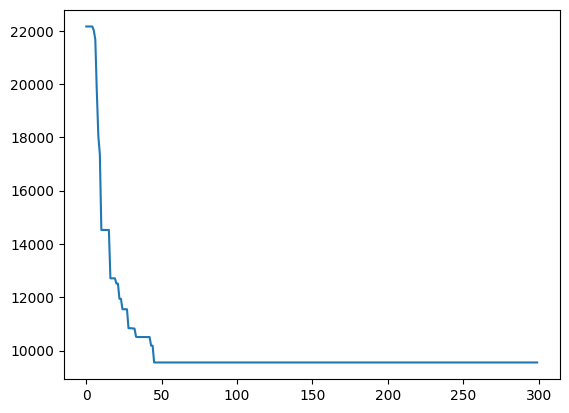

In [83]:
getInput('chr12a')
print("N:", N)
print("Matrix D:", len(D), 'x', len(D[0]))
print("Matrix F:", len(F), 'x', len(F[0]))
P, C, cost_history = PSO(n_particles=350, n_it=300,  w=0.1, c1=0.6, c2=0.8)
print("Optimal Solution:", list(P))
print("Best Cost:", C)
plt.plot(range(len(cost_history)), cost_history)

N: 32
Matrix D: 32 x 32
Matrix F: 32 x 32
Optimal Solution: [28, 29, 30, 6, 21, 4, 20, 1, 23, 26, 16, 10, 12, 31, 14, 3, 0, 22, 18, 15, 19, 8, 17, 27, 9, 2, 25, 7, 5, 11, 24, 13]
Best Cost: 156


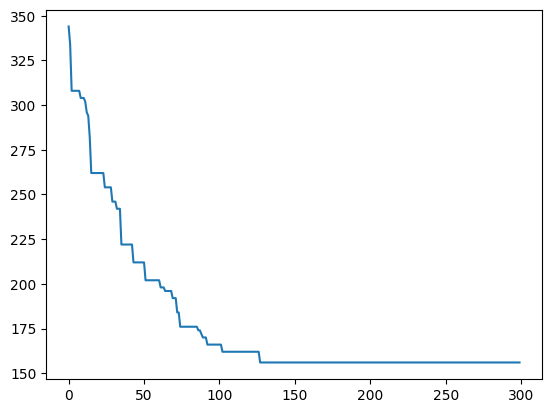

In [82]:
getInput('esc32a')
print("N:", N)
print("Matrix D:", len(D), 'x', len(D[0]))
print("Matrix F:", len(F), 'x', len(F[0]))
P, C, cost_history = PSO(n_particles=350, n_it=300,  w=0.1, c1=0.8, c2=0.8)
print("Optimal Solution:", list(P))
print("Best Cost:", C)
plt.plot(range(len(cost_history)), cost_history)

N: 20
Matrix D: 20 x 20
Matrix F: 20 x 20
Optimal Solution: [17, 13, 9, 2, 8, 3, 1, 11, 10, 15, 18, 14, 19, 7, 12, 16, 4, 6, 0, 5]
Best Cost: 2570


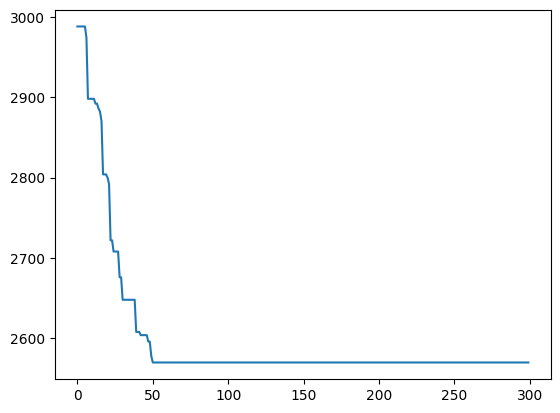

In [99]:
getInput('nug20')
print("N:", N)
print("Matrix D:", len(D), 'x', len(D[0]))
print("Matrix F:", len(F), 'x', len(F[0]))
P, C, cost_history = PSO(n_particles=500, n_it=300,  w=0.2, c1=0.8, c2=0.5)
print("Optimal Solution:", list(P))
print("Best Cost:", C)
plt.plot(range(len(cost_history)), cost_history)

N: 30
Matrix D: 30 x 30
Matrix F: 30 x 30
Optimal Solution: [17, 7, 10, 5, 24, 19, 11, 18, 1, 4, 20, 23, 6, 25, 16, 14, 9, 0, 22, 2, 27, 26, 28, 21, 8, 13, 15, 12, 29, 3]
Best Cost: 1897186


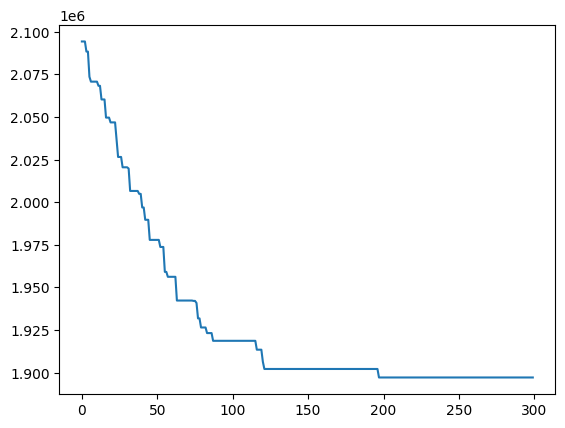

In [100]:
getInput('tai30a')
print("N:", N)
print("Matrix D:", len(D), 'x', len(D[0]))
print("Matrix F:", len(F), 'x', len(F[0]))
P, C, cost_history = PSO(n_particles=500, n_it=300,  w=0.2, c1=0.8, c2=0.5)
print("Optimal Solution:", list(P))
print("Best Cost:", C)
plt.plot(range(len(cost_history)), cost_history)

N: 50
Matrix D: 50 x 50
Matrix F: 50 x 50
Optimal Solution: [3, 26, 19, 22, 45, 15, 44, 20, 38, 40, 7, 12, 14, 11, 27, 41, 37, 25, 30, 2, 35, 24, 23, 28, 33, 29, 43, 9, 10, 4, 48, 16, 49, 46, 13, 32, 6, 47, 31, 1, 17, 39, 36, 18, 0, 21, 5, 42, 8, 34]
Best Cost: 63034


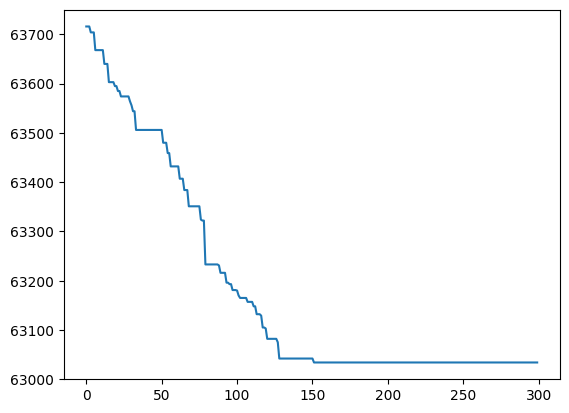

In [79]:
getInput('lipa50a')
print("N:", N)
print("Matrix D:", len(D), 'x', len(D[0]))
print("Matrix F:", len(F), 'x', len(F[0]))
P, C, cost_history = PSO(n_particles=350, n_it=300,  w=0.1, c1=0.8, c2=0.8)
print("Optimal Solution:", list(P))
print("Best Cost:", C)
plt.plot(range(len(cost_history)), cost_history)